## Input Images

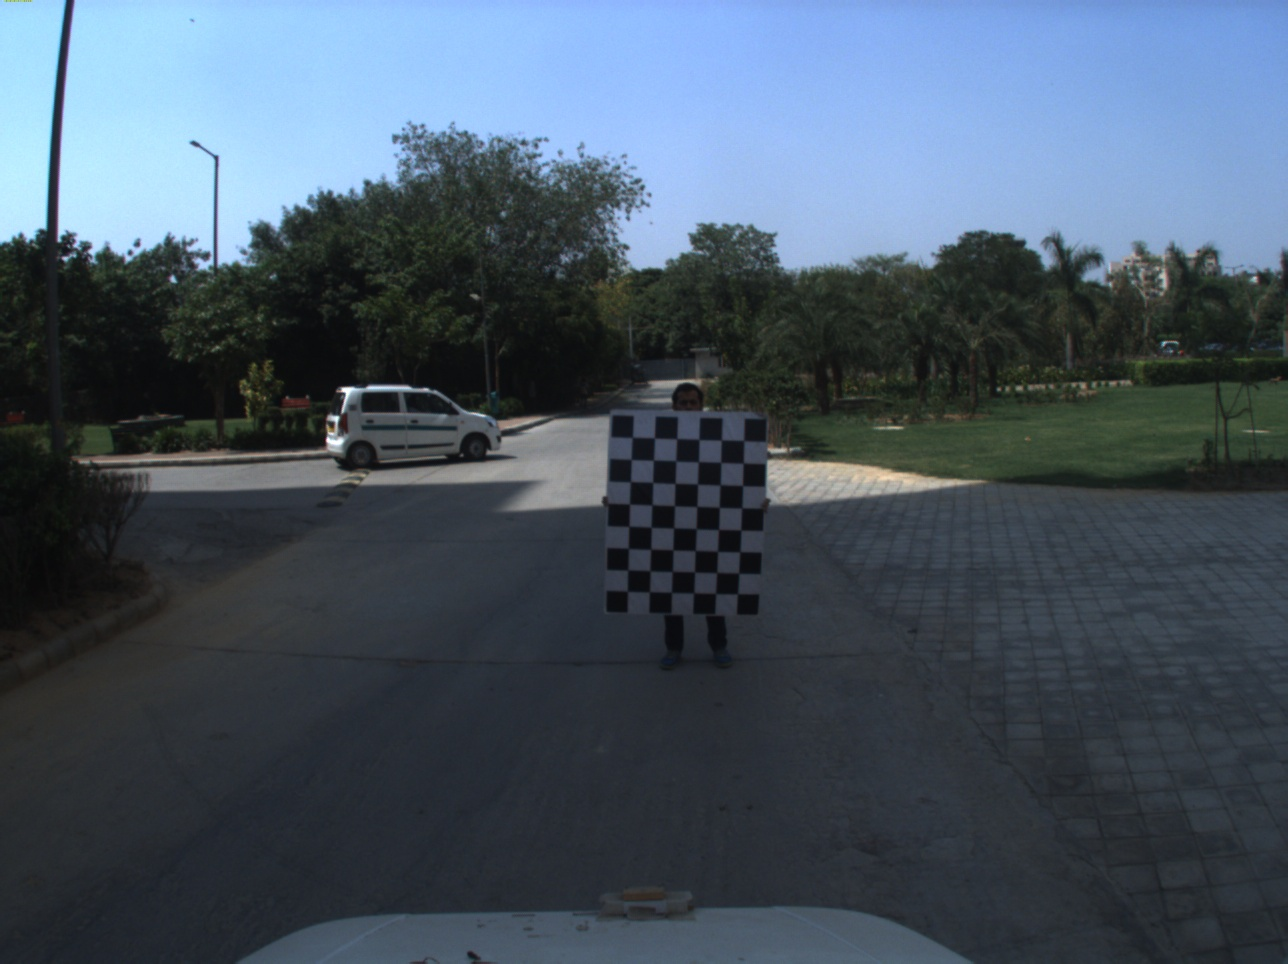


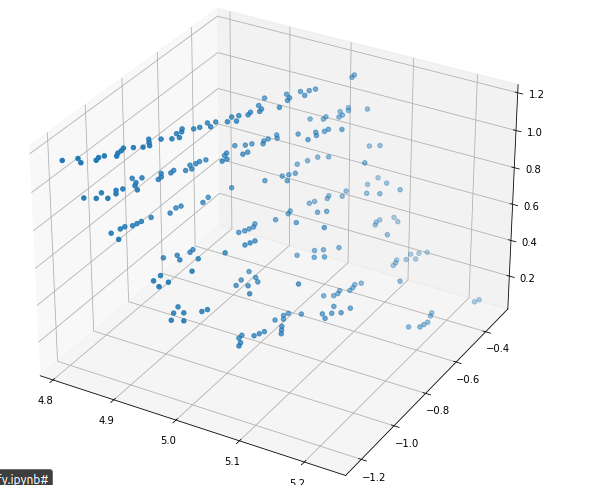

## Camera Calibration

In [1]:
import numpy as np
import cv2
import glob
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import scipy.spatial.distance
import random


In [2]:

def randomSampling(k ,cameraDist, lidarDist, lidarNormals):
    population = np.arange(0, 29, 1).tolist()
    randomPop = random.sample(population,k)

    sampledCameraDist = []
    sampledLidarDist = []
    sampledLidarNormals = []

    for i in range(len(randomPop)):
        sampledCameraDist.append(cameraDist[randomPop[i]])
        sampledLidarDist.append(lidarDist[randomPop[i]])
        sampledLidarNormals.append(lidarNormals[randomPop[i]])

    return sampledCameraDist, sampledLidarDist, sampledLidarNormals



In [3]:
def findNewVectors(rotationLTC, lidarNormals):
    
    lidarNormals = np.asarray(lidarNormals)
    lidarNormals = lidarNormals.reshape(np.shape(lidarNormals)[0], 3)
    return np.matmul(rotationLTC,lidarNormals)

def findCosineSimilarity(rotVectors,cameraNormals):

    rotVectors = np.asarray(rotVectors)
    rotVectors = rotVectors.reshape((29,3))
    meanRotatedVector = np.mean(rotVectors , axis = 0)

    dists = []
    for i in range(len(rotVectors)):
        dists.append(scipy.spatial.distance.cosine(rotVectors[i], cameraNormals[i]))

    return dists



In [4]:


def findLidarCentres(lidar_points):
    lidarCentres = []
    for i in range(len(lidar_points)):
        centre = (np.sum(lidar_points[i], axis = 0)/len(lidar_points[i])).reshape((3,1))
        lidarCentres.append(centre)

    return lidarCentres


## Rotation of Camera frame to Lidar frame
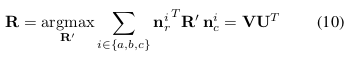

In [5]:

def rotateCameraToLidar(A,B):
    
    
    num_rows, num_cols = A.shape;

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    centroid_A = centroid_A.reshape((3,1))
    centroid_B = centroid_B.reshape((3,1))

    # subtract mean
    Am = A - np.tile(centroid_A, (1, num_cols))
    Bm = B - np.tile(centroid_B, (1, num_cols))

    # dot is matrix multiplication for array
    H = np.matmul(Am ,Bm.T)

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = np.matmul(Vt.T , U.T)

    
    
#     cam = A
#     lidar = B

#     H = np.cov(np.dot(cam, lidar.T))

#     # find rotation
#     U, S, Vt = np.linalg.svd(H)
#     R = np.matmul(Vt.T , U.T)
        
    
    
   # transformation = np.matmul(np.matmul(B,A.T),np.linalg.inv(np.matmul(A,A.T)))
    
    return R



In [20]:

def normalAndDistancesInLidarFrame(lidar_points):

    normals = []
    distances = []

    for i in range(len(lidar_points)):
        point = lidar_points[i]
        
        variables = np.concatenate((point[:,0:2] , np.ones((np.shape(point)[0],1),dtype=int)), axis = 1)
        rhs = point[:,2]
        rhs = rhs.reshape(np.shape(rhs)[0],1)

        x = np.linalg.lstsq(variables, rhs, rcond = None)
        #x = np.matmul(np.linalg.inv(np.matmul(variables.T,variables)),np.matmul(variables.T,rhs))
        normal = np.concatenate((x[0][0:2], -1 * np.ones((1,1))))

        modVal = math.sqrt(math.pow(normal[0],2) + math.pow(normal[1],2) + math.pow(normal[2],2))
        normal = normal/modVal
        
        # If n.p0 where p0 is any point lying on the plane < 0 , this means n is in the direction of the plane, otherwise in the opposite direction.
        # We need this step since by fixing c = -1, we are fixing the direction of c. Hence we must check the direction of normal with respect to the plane.

        sign = np.matmul(normal.T,point[0].reshape((3,1)))
        if(sign<0):
            normal = 0-normal
            
        normals.append(normal)

        d = (x[0][2]/modVal)[0]
        if(d<0):
            d = -d
        distances.append(d)
        
    return normals,distances


## Loading the data

###### The dataset has been split it two sets of 15 images and 14 images. Rotation and Tranlation vectors are calculated on the 15 images using the normals and centres of Camera and Lidar and are then cosine distance is calculated on the 14 different images for validation. 

In [7]:

def load_data():
    
    path = "/media/dheeraj/9A26F0CB26F0AA01/WORK/IIITD/Calibration/Calibration_Dataset/Dataset/training/"
    files=os.listdir(path)
    data,images,lidar_points=[],[],[]
    image_path=os.path.join(path,files[0])
    lidar_points_path=os.path.join(path, files[1])
    images_folder=os.listdir(image_path)
    lidar_points_folder=os.listdir(lidar_points_path)
    
    os.chdir(image_path)
    for i in images_folder:
        images.append(cv2.imread(i))
    
    os.chdir(lidar_points_path)
    
    for j in lidar_points_folder:
        lidar_points.append(np.load(j))
    
    for d in data:
        images.append(d['data'][0][0][0])
        lidar_points.append(d['data'][0][0][1])
    
    return images,lidar_points


def load_data_test():
    
    path = "/media/dheeraj/9A26F0CB26F0AA01/WORK/IIITD/Calibration/Calibration_Dataset/Dataset/validation"
    files=os.listdir(path)
    data,images,lidar_points=[],[],[]
    image_path=os.path.join(path,files[0])
    lidar_points_path=os.path.join(path, files[1])
    images_folder=os.listdir(image_path)
    lidar_points_folder=os.listdir(lidar_points_path)
    
    os.chdir(image_path)
    for i in images_folder:
        images.append(cv2.imread(i))
    
    os.chdir(lidar_points_path)
    
    for j in lidar_points_folder:
        lidar_points.append(np.load(j))
    
    for d in data:
        images.append(d['data'][0][0][0])
        lidar_points.append(d['data'][0][0][1])
    
    return images,lidar_points


In [8]:

def normalAndDistancesInCameraFrame(rotation,translation):

    normalInWorld = [0,0,1]
    normalInWorld = np.reshape(normalInWorld, (3,1))
    cameraNormals = []
    distances = []
    
    for i in range(len(rotation)):
        
        vector = np.matmul(rotation[i],normalInWorld)
        cameraNormals.append(vector)
        #dist = np.matmul(vector.T,translation[i])[0][0]
        dist = math.sqrt(tvecs[i][0]**2 + tvecs[i][1]**2 + tvecs[i][2]**2)
        distances.append(dist)

    return cameraNormals,distances


In [9]:

def get_Rotation_Vectors(rvecs):

    rvecs = np.asarray(rvecs)
    rotation_vectors = []

    for i in range(len(rvecs)):
        rotation_matrix = np.zeros(shape=(3,3))
        cv2.Rodrigues(rvecs[i], rotation_matrix)
        rotation_vectors.append(rotation_matrix)

    return rotation_vectors


In [13]:

def get_extrinsic_matrices(images, objpoints, imgpoints):

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    for img in images:
        
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (8,6),None)
        #print(corners)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners = np.reshape(corners, (48,2))
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            #print(corners2)
            
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return rvecs, tvecs


In [14]:


def calculateLidarCentres(lidar_points):
    lidarCentres = []
    for i in range(len(lidar_points)):
        centreX = np.mean(lidar_points[i][:,0])
        centreY = np.mean(lidar_points[i][:,1])
        centreZ = np.mean(lidar_points[i][:, 2])
        
        lidarCentres.append([centreX, centreY, centreZ])
    lidarCentres = np.asarray(lidarCentres)
    
    return lidarCentres


## Translation Vector from Camera frame to Lidar frame
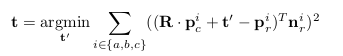

#### The given equation is converted in the form of:  Ax =B
#### And then we apply Least Square method to determine A 

In [33]:
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


images,lidar_points = load_data_test()
#print(np.shape(images))
lidar_points = np.asarray(lidar_points)
rvecs, tvecs = get_extrinsic_matrices(images, objpoints, imgpoints)
# print("tvecs shape : ",np.shape(tvecs))#.shape)
# print("rvecs shape : ", np.shape(rvecs))
# print("obj points : ", np.shape(objpoints))
#rint("lidar points shape : ",lidar_points)

/home/dheeraj/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
print(np.shape(rvecs))
print(tvecs[0])
print(np.shape(tvecs))


(14, 3, 1)
[[-13.30321046]
 [ -2.14914508]
 [ 34.36375117]]
(14, 3, 1)


In [34]:

rotation_vectors = get_Rotation_Vectors(rvecs)
cameraNormals, cameraDist= normalAndDistancesInCameraFrame(rotation_vectors,tvecs)
lidarNormals,lidarDist = normalAndDistancesInLidarFrame(lidar_points)

cameraCentres = tvecs
cameraCentres = np.asarray(tvecs)
#cameraCentres = cameraCentres.reshape(29, 3)
A=np.asarray(cameraNormals[0])
for i in range(1,len(cameraNormals)):
    A=np.hstack((A,cameraNormals[i]))

#print(A)

B=np.asarray(lidarNormals[0])
for i in range(1,len(lidarNormals)):
    B=np.hstack((B,lidarNormals[i]))


#lidarCentres = calculateLidarCentres(lidar_points)
lidarCentres = findLidarCentres(lidar_points)
lidarCentres = np.asarray(lidarCentres)


In [18]:

lidarNormals = np.asarray(lidarNormals)
cameraNormals = np.asarray(cameraNormals)


In [19]:
rotationCTL = rotateCameraToLidar(B,A)

### Rotation matrix Result

In [ ]:
print(rotationCTL)

In [ ]:

translationCTL = translateCameraToLidar(cameraCentres, cameraNormals, lidarCentres, lidarNormals, rotationCTL)


### Tranlational Vector Result

In [ ]:
translationCTL

In [ ]:



from scipy.spatial import distance

cameraNormals.shape
cosine_distance = []
newLidarNormals = []
for i in range(len(cameraNormals)):
    newLidarNormals.append(np.dot( rotationCTL,cameraNormals[i]))
newLidarNormals = np.asarray(newLidarNormals)
#newLidarNormals

for i in range(len(newLidarNormals)):
    cosine_distance.append(distance.cosine(lidarNormals[i], newLidarNormals[i]))
    
cosine_distance

np.mean(cosine_distance)

## Rough work

In [ ]:
for i in range(len(lidarCentres)):
    #print(cameraCentres[i], rotationCTL)
    print(np.subtract(lidarCentres[i], np.matmul(cameraCentres[i].T, rotationCTL.T)))
    break
print(np.dot(cameraCentres[0].T, rotationCTL.T))

## Verification

In [ ]:
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.


images,lidar_points = load_data_test()
lidar_points = np.asarray(lidar_points)
rvecs, tvecs = get_extrinsic_matrices(images, objpoints, imgpoints)


rotation_vectors = get_Rotation_Vectors(rvecs)
cameraNormals, cameraDist= normalAndDistancesInCameraFrame(rotation_vectors,tvecs)
lidarNormals,lidarDist = normalAndDistancesInLidarFrame(lidar_points)
cameraCentres = tvecs
cameraCentres = np.asarray(tvecs)
#cameraCentres = cameraCentres.reshape(29, 3)
A=np.asarray(cameraNormals[0])
for i in range(1,len(cameraNormals)):
    A=np.hstack((A,cameraNormals[i]))

#print(A)

B=np.asarray(lidarNormals[0])
for i in range(1,len(lidarNormals)):
    B=np.hstack((B,lidarNormals[i]))



#lidarCentres = calculateLidarCentres(lidar_points)
lidarCentres = findLidarCentres(lidar_points)
lidarCentres = np.asarray(lidarCentres)

lidarNormals = np.asarray(lidarNormals)
cameraNormals = np.asarray(cameraNormals)

from scipy.spatial import distance

cosine_distance = []
newLidarNormals = []
for i in range(len(cameraNormals)):
    newLidarNormals.append(np.dot(rotationCTL.T, cameraNormals[i]))
newLidarNormals = np.asarray(newLidarNormals)
#newLidarNormals

for i in range(len(newLidarNormals)):
    cosine_distance.append(distance.cosine(newLidarNormals[i], lidarNormals[i]))
    
(cosine_distance)
np.mean(cosine_distance)
#lidarNormals

## Results for normal alignment

In [ ]:
index=0
for cameraNormal,lidarNormal in zip(cameraNormals,lidarNormals):
    fig=plt.figure()
    ax=fig.gca(projection='3d')
    rotatedVector=np.dot(rotationCTL.T,cameraNormal)
    #x, y, z = np.meshgrid(np.arange(-0.8, 1, 0.2),np.arange(-0.8, 1, 0.2),np.arange(-0.8, 1, 0.8))
    ax.quiver(0,0,0,cameraNormal[0],cameraNormal[1],cameraNormal[2],length=0.1,normalize=True,color="blue")
    ax.quiver(0,0,0,lidarNormal[0],lidarNormal[1],lidarNormal[2],length=0.1,normalize=True,color="red")
    #ax.quiver(pts[0][0],pts[0][1],pts[0][2],normal_camera_approx[0],normal_camera_approx[1],normal_camera_approx[2],length=0.1,normalize=True,color="green")
    ax.quiver(0,0,0,rotatedVector[0],rotatedVector[1],rotatedVector[2],length=0.1,normalize=True,color="green")
    #fig= plt.figure(figsize = (6,6))
    #fig.add_subplot(3, i, 1)
    plt.show()
    if(index == 10):
        break
    index+=1


## Equation of the plane



In [ ]:
newLidarCentres = []
print(translationCTL.shape)
for i in range(len(cameraCentres)):
    newLidarCentres.append(np.add(np.dot(rotationCTL.T, cameraCentres[i]), translationCTL))
newLidarCentres = np.asarray(newLidarCentres)
newLidarCentres


for i in range(len(newLidarCentres)):
    cosine_distance.append(distance.cosine(newLidarCentres[i], lidarCentres[i]))
    
(cosine_distance)
np.mean(cosine_distance)




In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')

(x, y) = np.meshgrid(np.arange(-2, 2.1, 1), np.arange(-1, 1.1, .25))
z = x + y
print(x.shape)
print
print(lidar_points[0][2].shape)
print(z.shape)
ax.plot_surface(x, y, z, cmap=cm.copper)
ax.set(xlabel='x', ylabel='y', zlabel='z', title='z = x + y')

fig.tight_layout()

In [ ]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = np.cos(x ** 2 + y ** 2)
print(z.shape)
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')

ax.plot_surface(x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('Surface plot')
plt.show()

In [ ]:
p1 = np.array(lidar_points[0][0])
p2 = np.array(lidar_points[0][6])
p3 = np.array(lidar_points[0][15])


# These two vectors are in the plane
v1 = p3 - p1
v2 = p2 - p1

# the cross product is a vector normal to the plane
cp = np.cross(v1, v2)
a, b, c = cp

# This evaluates a * x3 + b * y3 + c * z3 which equals d
d = np.dot(cp, p3)

print('The equation is {0}x + {1}y + {2}z = {3}'.format(a, b, c, d))


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-2, 14, 5)
y = np.linspace(-2, 14, 5)
X, Y = np.meshgrid(x, y)

Z = (d - a * X - b * Y) / c

# plot the mesh. Each array is 2D, so we flatten them to 1D arrays
ax.plot(X.flatten(),
        Y.flatten(),
        Z.flatten(), 'bo ')

# plot the original points. We use zip to get 1D lists of x, y and z
# coordinates.
ax.plot(*zip(p1, p2, p3), color='r', linestyle=' ', marker='o')

# adjust the view so we can see the point/plane alignment
ax.view_init(0, 22)
plt.show()



In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1, 1, 1, projection='3d')

x = np.array(lidar_points[:,0])
y = np.array(lidar_points[0][1])
z = np.array(lidar_points[0])

ax.plot_surface(x, y, z)
ax.set(xlabel='x', ylabel='y', zlabel='z')

fig.tight_layout()
#fig.savefig('PatchExOrig_py.png')